# Custom masks for sampling with MaskedZarrDataset

In [1]:
import zarrdataset as zds
import zarr

In [2]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = ["https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.4/idr0073A/9798462.zarr"]

In [3]:
z_img = zarr.open(filenames[0], mode="r")
z_img["0"].info

Name,/0
Type,zarr.core.Array
Data type,uint8
Shape,"(1, 3, 1, 16433, 21115)"
Chunk shape,"(1, 1, 1, 1024, 1024)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,1040948385 (992.7M)
Chunks initialized,0/1071


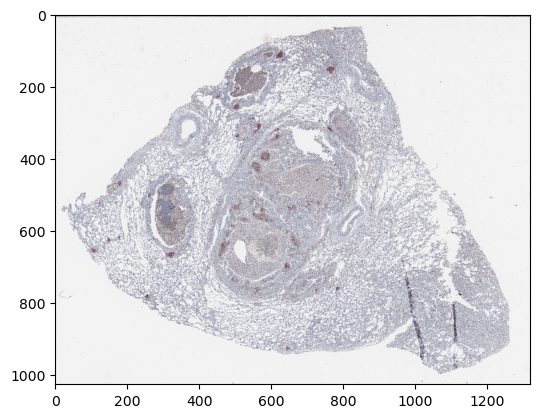

In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.moveaxis(z_img["4"][0, :, 0], 0, -1))
plt.show()

Define a mask from where patches can be extracted

In [25]:
from skimage import color, filters, morphology

In [33]:
im_gray = color.rgb2gray(z_img["4"][0, :, 0], channel_axis=0)
thresh = filters.threshold_otsu(im_gray)

mask = im_gray > thresh
mask = morphology.remove_small_objects(mask == 0, min_size=16 ** 2,
                                       connectivity=2)
mask = morphology.remove_small_holes(mask, area_threshold=128)
# mask = morphology.binary_dilation(mask, morphology.disk(8))

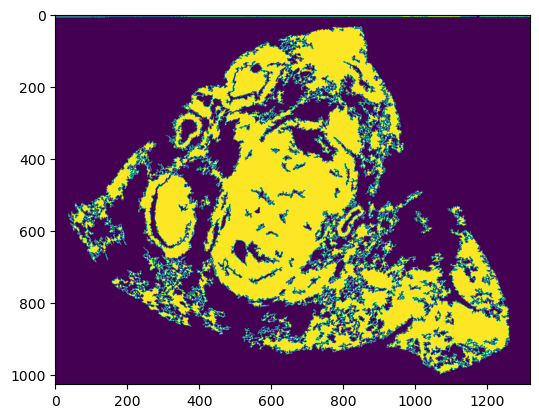

In [34]:
plt.imshow(mask)
plt.show()

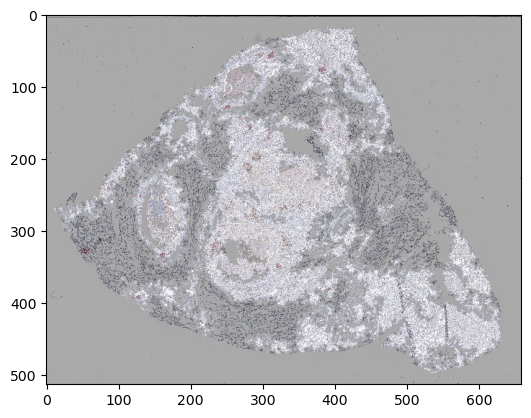

In [8]:
plt.imshow(np.moveaxis(z_img["5"][0, :, 0], 0, -1))
plt.imshow(mask, cmap="gray", alpha=0.5)
plt.show()

### Extract patches of size 512x512 pixels from a Whole Slide Image (WSI)

Sample the image uniformly in a squared grid pattern

In [9]:
patch_size = dict(Y=512, X=512)
patch_sampler = zds.GridPatchSampler(patch_size=patch_size)

Use the MaskedZarrDataset class to enable extraction of samples from masked regions.

An extra dimension is added to the mask, so it matches the number of spatial axes in the image

In [10]:
my_dataset = zds.MaskedZarrDataset(filenames,
                                   data_group="1",
                                   source_axes="TCZYX",
                                   patch_sampler=patch_sampler,
                                   return_any_label=False,
                                   mask_filenames=[mask[None, ...]],
                                   mask_source_axes="ZYX",
                                   mask_axes="ZYX",
                                   mask_data_group="")

In [11]:
ds_iterator = iter(my_dataset)

In [12]:
sample = next(ds_iterator)
type(sample), sample.shape, sample.dtype

(numpy.ndarray, (1, 3, 1, 512, 512), dtype('uint8'))

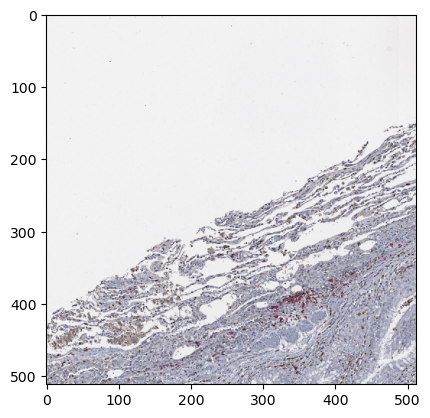

In [13]:
plt.imshow(np.moveaxis(sample[0, :, 0], 0, -1))
plt.show()

In [14]:
samples = []
for i, sample in enumerate(my_dataset):
    samples.append(np.moveaxis(sample[0, :, 0], 0, -1))

    if i > 5:
        # Take only five samples for illustration purposes
        break

samples = np.hstack(samples)

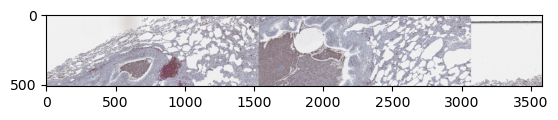

In [15]:
plt.imshow(samples)
plt.show()

# Use a function to generate the masks for each image in the dataset

In [16]:
patch_size = dict(Y=512, X=512)
patch_sampler = zds.GridPatchSampler(patch_size=patch_size)

Apply WSITissueMaskGenerator transform to each image in the dataset to define each sampling mask

In [17]:
mask_func = zds.WSITissueMaskGenerator(mask_scale=1,
                                       min_size=16,
                                       area_threshold=128,
                                       axes="ZYX")

Because the input image (zarr group "1") is big, computing the mask directly on that could require high computational resources.

For that reason, use a donwsampled version of that image, which is located in group "4" (a 1/16th of the input image).

The image axes must permuted to match the WSITissueMaskGenerator required input axes `required_source_axes`.

This is achieved by defining a ROI that extracts only the spatial axes, and color channels from the image.

In [35]:
my_dataset = zds.MaskedZarrDataset(filenames,
                                   data_group="1",
                                   source_axes="TCZYX",
                                   patch_sampler=patch_sampler,
                                   return_any_label=False,
                                   mask_func=mask_func,
                                   mask_filenames=None,
                                   mask_data_group="4",
                                   mask_source_axes="TCZYX",
                                   mask_roi="(0,0,0,0,0):(1,-1,1,-1,-1)",
                                   mask_axes="YXC",
                                   shuffle=True)

In [36]:
ds_iterator = iter(my_dataset)

In [37]:
sample = next(ds_iterator)
type(sample), sample.shape, sample.dtype

(numpy.ndarray, (1, 3, 1, 512, 512), dtype('uint8'))

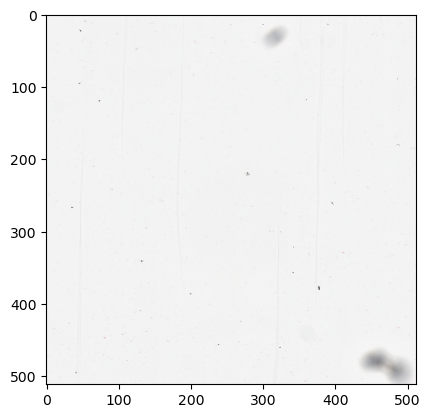

In [38]:
plt.imshow(np.moveaxis(sample[0, :, 0], 0, -1))
plt.show()

In [39]:
samples = []
for i, sample in enumerate(my_dataset):
    samples.append(np.moveaxis(sample[0, :, 0], 0, -1))

    if i > 5:
        # Take only five samples for illustration purposes
        break

samples = np.hstack(samples)

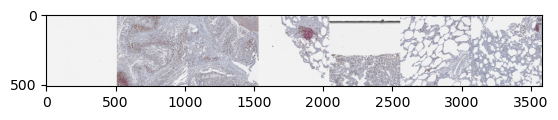

In [40]:
plt.imshow(samples)
plt.show()